Copyright 2025 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# @title TIPS Demo notebook

#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at

#  https://www.apache.org/licenses/LICENSE-2.0

#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.

### Imports and functions

Please follow the installation guide before you run the following cells.

In [7]:
import glob
import os
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
from PIL import Image
import mediapy as media
import tensorflow_text

from tips.scenic.configs import tips_model_config
from tips.scenic.models import text
from tips.scenic.models import tips
from tips.scenic.utils import checkpoint
from tips.scenic.utils import feature_viz

def load_and_preprocess_image(image_path, image_shape):
  with open(image_path, 'rb') as f:
    image = np.array(Image.open(f)).astype(np.float32) / 255.
  image = jax.image.resize(image, (*image_shape, 3), method='bilinear')
  return image.astype(np.float32)

### Configure the TIPS model.

In [3]:
# Set the input image shape.
image_width = 448  # @param {type: "number"}
image_shape = (image_width,) * 2

variant = 'tips_oss_b14_highres_distilled'  # @param ['tips_oss_g14_highres', 'tips_oss_g14_lowres', 'tips_oss_so400m14_highres_largetext_distilled', 'tips_oss_l14_highres_distilled', 'tips_oss_b14_highres_distilled', 'tips_oss_s14_highres_distilled']

# Model and checkpoint configuration.
model_config = tips_model_config.get_config(variant)

# Add the checkpoints in this directory.
checkpoint_dir = '../checkpoints/'  # @param {type: "string"}


### Load the vision and text encoders.

In [6]:
# Load the vision encoder.
model_vision = tips.VisionEncoder(
    variant=model_config.variant,
    pooling=model_config.pooling,
    num_cls_tokens=model_config.num_cls_tokens,
)

init_params_vision = model_vision.init(
    jax.random.PRNGKey(0), jnp.ones([1, *image_shape, 3]), train=False)

print(f'Loading the vision encoder weights for variant {variant}.')
params_vision = checkpoint.load_checkpoint(
    os.path.join(checkpoint_dir, f'{variant}_vision.npz'),
    init_params_vision['params'])
print('Done.')

# Load the text encoder.
model_text = tips.TextEncoder(
    variant=model_config.variant)
init_params_text = model_text.init(
    jax.random.PRNGKey(0),
    ids=jnp.ones((2, 64), dtype=jnp.int32),
    paddings=jnp.zeros((2, 64), dtype=jnp.int32),
    train=False)
init_params_text['params']['temperature_contrastive'] = np.array(0, dtype=np.float32)
print(f'Loading the text encoder weights for variant {variant}')
params_text = checkpoint.load_checkpoint(
    os.path.join(checkpoint_dir, f'{variant}_text.npz'),
    init_params_text['params'])
print('Done.')

# Load the tokenizer.
tokenizer_path = os.path.join(checkpoint_dir, 'tokenizer.model')
tokenizer = text.Tokenizer(tokenizer_path)

### Run inference and visualize the results.

Input image,"a toy dinosaur, prob: 100.0%"

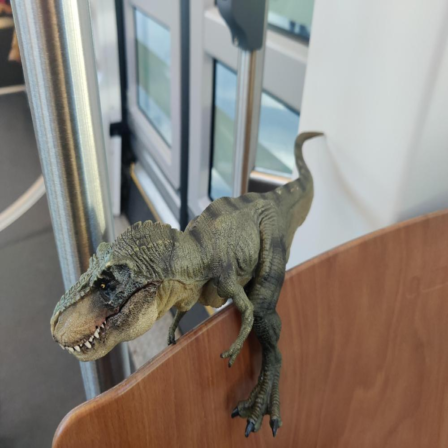
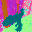

Input image,"a cat, prob: 99.9%"

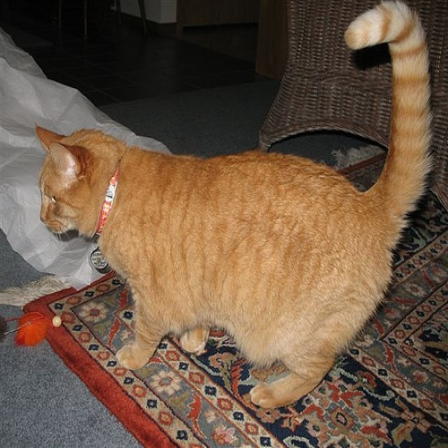
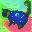

In [5]:
# Add your images in this directory.
image_dir = '../images/'  # @param {type: "string"}
image_paths = glob.glob(os.path.join(image_dir, '*'))

# The text inputs to be contrasted.
text_inputs = [
    'A ship',
    'holidays',
    'a toy dinosaur',
    'Two astronauts',
    'A streetview image of a fastfood restaurant',
    'a cat',
    'a dog',
    'two cows',
]

for image_path in image_paths:
  # Load the image.
  image = load_and_preprocess_image(image_path, image_shape)

  # Run inference on the image.
  spatial_features, embeddings_vision = model_vision.apply(
      {'params': params_vision}, image[None], train=False)
  cls_token = feature_viz.normalize(embeddings_vision[:, 0, :])  # Choose the first CLS token.

  # Run inference on text.
  text_ids, text_paddings = tokenizer.tokenize(text_inputs, max_len=64)
  embeddings_text = model_text.apply(
      {'params': params_text},
      ids=text_ids,
      paddings=text_paddings,
      train=False)
  embeddings_text = feature_viz.normalize(embeddings_text)

  # Compute cosine similariy.
  cos_sim = nn.softmax(
      ((cls_token @ embeddings_text.T) /
       params_text['temperature_contrastive']), axis=-1)
  label_idxs = jnp.argmax(cos_sim, axis=-1)
  cos_sim_max = jnp.max(cos_sim, axis=-1)
  label_predicted = text_inputs[label_idxs[0].item()]
  similarity = cos_sim_max[0].item()

  # Visualize the results.
  pca_obj = feature_viz.PCAVisualizer(spatial_features)
  image_pca = pca_obj(spatial_features)[0]
  media.show_images(
      [image, image_pca], width=image_width,
      titles=['Input image', f'{label_predicted},  prob: {similarity*100:.1f}%']
  )